## 1 Neural Networks

In [24]:
from scipy.io import loadmat
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np

### 1.1 Dataset

In [25]:
data1 = loadmat("./ex4data1.mat")
X = data1["X"]
y = data1["y"]
print(f"Shape of X is {X.shape}")
print(f"Shape of y is {y.shape}")
# y[y==10] = 0

Shape of X is (5000, 400)
Shape of y is (5000, 1)


### 1.2 Visualizing the data

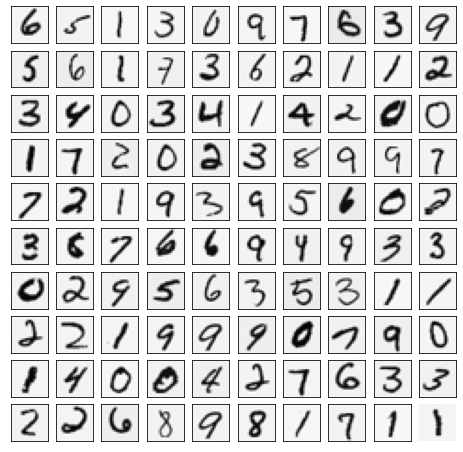

In [26]:
plt.figure(figsize=(8, 8))
for i in range(1, 11):
    for j in range(1, 11):
        pick = np.random.randint(0, 5000)
        image_pick = X[pick, : ].reshape((20, 20))
        plt.subplot(10, 10, 10 * (i - 1) + j)
        plt.imshow(image_pick.transpose(), cmap="binary")
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
plt.axis("off")
plt.show()

### 1.3 Feedforward and cost function

In [27]:
Theta = loadmat("./ex4weights.mat")
theta1 = Theta["Theta1"]
theta2 = Theta["Theta2"]
print(f"Shape of theta1 is {theta1.shape}")
print(f"Shape of theta2 is {theta2.shape}")

Shape of theta1 is (25, 401)
Shape of theta2 is (10, 26)


In [28]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [38]:
def nnCostFunction(nn_params, input_layer_size, 
    hidden_layer_size, num_labels, X, y, lamda=0):
    theta1_size = (hidden_layer_size, input_layer_size+1)
    theta2_size = (num_labels, hidden_layer_size+1)
    assert len(nn_params) == theta1_size[0]*theta1_size[1] + theta2_size[0] * theta2_size[1]
    theta1 = nn_params[:theta1_size[0]*theta1_size[1]].reshape(theta1_size)
    theta2 = nn_params[theta1_size[0]*theta1_size[1]:].reshape(theta2_size)
    
    # Encode y
    one_hot = np.eye(num_labels)[y.squeeze()-1]
    m = X.shape[0]
    J = 0
    for i in range(m):
        # Feedforward 
        a1 = X[i:i+1, :].T
        yi = one_hot[i:i+1, :].T
        a1 = np.r_[np.array([[1.]]), a1]
        z2 = theta1 @ a1
        a2 = sigmoid(z2)
        a2 = np.r_[np.array([[1.]]), a2]
        z3 = theta2 @ a2 
        a3 = sigmoid(z3)
        J = J - np.sum(yi * np.log(a3) + (1 - yi) * np.log(1 - a3))

    J = J / m
    
    return J

In [39]:
nn_params = np.r_[theta1.flatten(), theta2.flatten()]

In [40]:
J = nnCostFunction(nn_params, 400, 25, 10, X, y)
J

0.2876291651613188

## 1.4 Regularized cost function

In [41]:
def nnCostFunction(nn_params, input_layer_size, 
    hidden_layer_size, num_labels, X, y, lamda=0):
    theta1_size = (hidden_layer_size, input_layer_size+1)
    theta2_size = (num_labels, hidden_layer_size+1)
    assert len(nn_params) == theta1_size[0]*theta1_size[1] + theta2_size[0] * theta2_size[1]
    theta1 = nn_params[:theta1_size[0]*theta1_size[1]].reshape(theta1_size)
    theta2 = nn_params[theta1_size[0]*theta1_size[1]:].reshape(theta2_size)
    
    # Encode y
    one_hot = np.eye(num_labels)[y.squeeze()-1]
    m = X.shape[0]
    J = 0
    for i in range(m):
        # Feedforward 
        a1 = X[i:i+1, :].T
        yi = one_hot[i:i+1, :].T
        a1 = np.r_[np.array([[1.]]), a1]
        z2 = theta1 @ a1
        a2 = sigmoid(z2)
        a2 = np.r_[np.array([[1.]]), a2]
        z3 = theta2 @ a2 
        a3 = sigmoid(z3)
        J = J - np.sum(yi * np.log(a3) + (1 - yi) * np.log(1 - a3))

    J = J / m
    
    # Regularization term
    reg = lamda * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:]))) / (2*m)
    
    return J+reg

In [42]:
J = nnCostFunction(nn_params, 400, 25, 10, X, y, 1)
J

0.38376985909092354

## 2 Backpropagation

### 2.1 Sigmoid gradient

In [12]:
def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

### 2.2 Random initialization

In [17]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    theta = np.random.rand(L_out, L_in+1) * 2 * epsilon_init - epsilon_init
    return theta

In [53]:
theta10 = randInitializeWeights(400, 25)
theta20 = randInitializeWeights(25, 10)
nn_params0 = np.r_[theta10.flatten(), theta20.flatten()]

### 2.3 Backpropagation

In [44]:
def nnCostFunction(nn_params, input_layer_size, 
    hidden_layer_size, num_labels, X, y, lamda=0):
    theta1_size = (hidden_layer_size, input_layer_size+1)
    theta2_size = (num_labels, hidden_layer_size+1)
    assert len(nn_params) == theta1_size[0]*theta1_size[1] + theta2_size[0] * theta2_size[1]
    theta1 = nn_params[:theta1_size[0]*theta1_size[1]].reshape(theta1_size)
    theta2 = nn_params[theta1_size[0]*theta1_size[1]:].reshape(theta2_size)
    
    # Encode y
    one_hot = np.eye(num_labels)[y.squeeze()-1]
    m = X.shape[0]
    J = 0
    grad1 = np.zeros_like(theta1)
    grad2 = np.zeros_like(theta2)
    for i in range(m):
        # Feedforward 
        a1 = X[i:i+1, :].T
        yi = one_hot[i:i+1, :].T
        a1 = np.r_[np.array([[1.]]), a1]
        z2 = theta1 @ a1
        a2 = sigmoid(z2)
        a2 = np.r_[np.array([[1.]]), a2]
        z3 = theta2 @ a2 
        a3 = sigmoid(z3)
        J = J - np.sum(yi * np.log(a3) + (1 - yi) * np.log(1 - a3))
        # Backpropagation
        delta3 = a3 - yi 
        delta2 = (theta2.T @ delta3)[1:, :] * (sigmoidGradient(z2))
        grad2 = grad2 + delta3 @ a2.T
        grad1 = grad1 + delta2 @ a1.T

    J = J / m
    # Regularization term
    reg = lamda * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:]))) / (2*m)
    theta1[:, 1] = 0 
    theta2[:, 1] = 0
    grad1 = grad1 / m + lamda * theta1 / m 
    grad2 = grad2 / m + lamda * theta2 / m
    grad = np.r_[grad1.flatten(), grad2.flatten()]

    return J+reg, grad 

### 2.4 Gradient checking

In [47]:
J, grad = nnCostFunction(nn_params, 400, 25, 10, X, y)

### 2.6 Learning parameters


In [68]:
result = minimize(nnCostFunction, x0=nn_params0, args=(400, 25, 10, X, y), method="L-BFGS-B", jac=True, options={"maxiter":400})
if result.success:
    nn_params = result.x

In [69]:
def predict(X, nn_params):
    theta1 = nn_params[:401*25].reshape((25, 401))
    theta2 = nn_params[401*25:].reshape((10, 26))
    X = np.c_[np.ones((len(X), 1)), X]
    z1 = X @ theta1.T
    a1 = sigmoid(z1)
    a1 = np.c_[np.ones((len(a1), 1)), a1]
    z2 = a1 @ theta2.T
    a2 = sigmoid(z2)
    y_pred = (np.argmax(a2, axis=1)+1)
    return y_pred[:, np.newaxis]


In [70]:
y_pred = predict(X, nn_params)
print(f"Traning set accuracy is {np.mean(y==y_pred):%}")

Traning set accuracy is 97.120000%


## 4 Visualizing the hiden layer

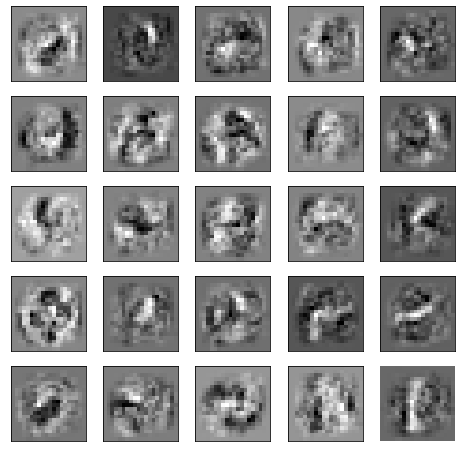

In [72]:
theta1 = nn_params[:401*25].reshape((25, 401))
theta1 = theta1[:, 1:]
plt.figure(figsize=(8, 8))
for i in range(25):
    thetai = theta1[i].reshape((20, 20))
    plt.subplot(5, 5, i+1)
    plt.imshow(thetai, cmap="binary")
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.axis("off")
plt.show()